# Model for one Coulomb scatter
Let's see how we can model a Coulomb scatter. We assume here in this exercise that the deflection angle $\theta$ is uniformly distributed within a spread from $-\theta_\text{max}$ to $+\theta_\text{max}$. 

We will draw our tracker with only one layer (as we want to model first one scatter).
Then we will generate a big $N$ number of $\theta$ values, uniformly distributed with a known parameter $\theta_\text{max}$. That will be our reference distribution. 
We will do as if we do not know this $\theta_\text{max}$ and try to find it by:

 1. Generating a 'guessed' uniformed distribution for a tested parameter $\theta_\text{max, guess 1}$

 2. Computing the $\sum \chi^2$ for this guess.
 3. Repeating this for several distributions generated with different $\theta_\text{max, guess i}$
 4. Getting the value of $\theta_\text{max, guess k}$ for which the $\sum \chi^2$ is minimum.
 
 Hopefully we find 45$^\circ$!


In [6]:
import sys
import matplotlib.pyplot as plt
import toyTracker as tk

Let's get our tracker plotted. Just the incident track for now.

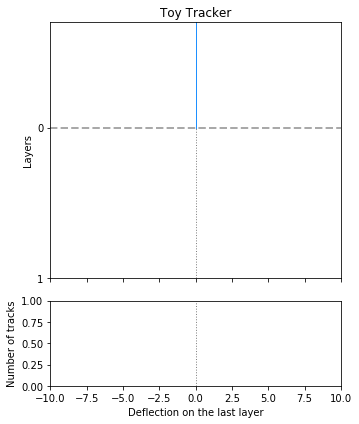

In [8]:
minx = -10.
maxx = +10.
fig, ax = tk.buildDetector(1, minx, maxx)
fig.show()
fig.canvas.draw()

Let's get a lot of data! 

In [9]:
import random
import numpy as np

thetaMax = 45 # degrees

nPointsData  = 10000
thetas       = []
for t in range(nPointsData):
    aTheta = 2*thetaMax * random.uniform(0 , 1) - thetaMax
    thetas.append(aTheta)

How does the stored values of theta look like? Let's plot that:

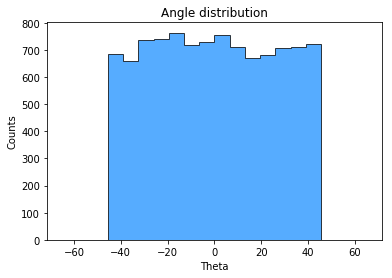

In [10]:
fig2 = plt.figure()
plt.title('Angle distribution')
plt.xlabel('Theta')
plt.ylabel('Counts')
n, binArray, patches = plt.hist(thetas, 20, range=[-65, 65], 
                               histtype='stepfilled', color='dodgerblue', alpha=0.75 , ec="k")
fig2.show()

Our current goal is to get what is the parameter of the distribution of $\theta$ from the distribution. Here it is easy to guess the max is $\theta_\text{max}$ is 45$^{\circ}$ because we ... set it. And see it too. But let's presume we don't know and we shoot a distribution with... let's say $\theta_\text{max, guess} = 30^{\circ}$.

Make a function, like the one computed above, to generate a uniform distribution: 
 * it should take as input parameter the currently tested/guessed $\theta_\text{max,guess}$ (here 30$^{\circ}$)
 * the size of the guessed distribution 
 Remember: the bigger the size, the better for reducing fluctuations. But it takes more time to compute!

As output it should get the distribution of the $\theta$ spread uniformly from -$\theta_\text{max, guess}$ to +$\theta_\text{max, guess}$.

Plot the data and the guessed distributions over the range -80. to 80 with 20 bins.

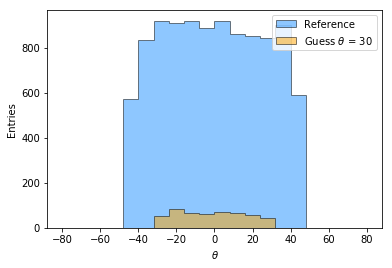

In [11]:
def getThetaDistributions(thetaMaxGuess, N_points):
    
    # Declaring the empty list we will fill:
    thetas  = []

    for p in range(N_points):
        aTheta = 2*thetaMaxGuess * random.uniform(0 , 1) - thetaMaxGuess
        thetas.append(aTheta)
        
    return thetas

thetaMax     = 30
nPointsGuess = 500

myGuessedThetas = getThetaDistributions(thetaMax, nPointsGuess)

minx = -80.
maxx = +80.
nbins=  20

# Let's plot this on top of our real theta:
fig = plt.figure()
histoData, binEdges, ignored = plt.hist(thetas,          nbins, range=[minx, maxx], label='Reference', 
                                           histtype='stepfilled', color='dodgerblue', alpha=0.5 , ec="k")

histoGuess, binEdgs, ignored = plt.hist(myGuessedThetas, nbins, range=[minx, maxx], label=r'Guess $\theta$ = 30', 
                                           histtype='stepfilled', color='orange', alpha=0.5 , ec="k")

plt.ylabel("Entries")
plt.xlabel(r"$\theta$")
plt.legend()
fig.show()

Oh, difference in size. Let's add error the error bars on this plot.
(we assume the entries for each distribution are all uncorrelated).

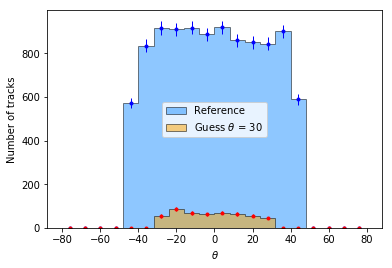

In [12]:
bin_centers       = 0.5 * (binEdges[:-1] + binEdges[1:])

histoDataSigma  = np.sqrt(histoData)
histoGuessSigma = np.sqrt(histoGuess)

fig = plt.figure()
histoData, binEdges, ignored = plt.hist(thetas,          20, range=[-80, 80], label='Reference', 
                                           histtype='stepfilled', color='dodgerblue', alpha=0.5 , ec="k")
plt.errorbar(bin_centers, histoData, yerr=histoDataSigma, fmt='b.')
histoGuess,binEdges, ignored = plt.hist(myGuessedThetas, 20, range=[-80, 80], label=r'Guess $\theta$ = 30', 
                                           histtype='stepfilled', color='orange', alpha=0.5 , ec="k")
plt.errorbar(bin_centers, histoGuess, yerr=histoGuessSigma, fmt='r.')
plt.ylabel("Number of tracks")
plt.xlabel(r"$\theta$")
plt.legend()
fig.show()

We need to normalize these distributions.
Plot them again with area = 1 for both of them.
Careful to handle the statistical error bars correctly!

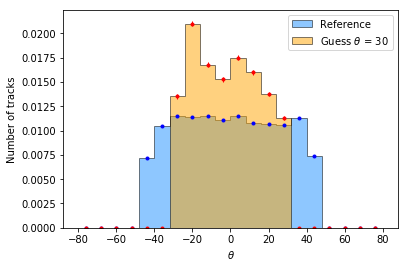

In [22]:
fig = plt.figure()

histoDataNorm,  binEdges, ignored     = plt.hist(thetas,         nbins, range=[minx, maxx], label='Reference', density=True, histtype='stepfilled', color='dodgerblue', alpha=0.5 , ec="k")
histoDataSigmaNorm = (1./nPointsData)*np.sqrt(histoDataNorm)
plt.errorbar(bin_centers, histoDataNorm, yerr=histoDataSigmaNorm, fmt='b.')

histoGuessNorm, binEdges, ignored     = plt.hist(myGuessedThetas, nbins, range=[minx, maxx], label=r'Guess $\theta$ = 30', density=True, histtype='stepfilled', color='orange', alpha=0.5 , ec="k")
histoGuessSigmaNorm  = (1./nPointsGuess)*np.sqrt(histoGuessNorm)
plt.errorbar(bin_centers, histoGuessNorm, yerr=histoGuessSigmaNorm, fmt='r.')

plt.ylabel("Number of tracks")
plt.xlabel(r"$\theta$")
plt.legend()
fig.show()

It's not quite a good guess right?
So now I will make a function to compute the chi-Square between these two distributions. 

For now I just want to print the values of the histograms I see above, to know I am 'reading' them correctly in my code. Will print only one bin out of 2.

In [23]:
# Check if my two arrays are the same size:
if len(histoDataNorm) == len(histoGuessNorm):
    print("The two histograms have the same number of bins. Good.")
else:
    print("Uhoh. Problem. Need the same number of bins for comparing two distributions.")
    sys.exit(0)
    
for i in range(len(histoDataNorm)):
    if i%2 == 0: # printing even number of bin
        print("Bin %d\tRef histo (blue) = %.5f\tGuess (orange) = %.5f"%(i,histoDataNorm[i],histoGuessNorm[i]))

The two histograms have the same number of bins. Good.
Bin 0	Ref histo (blue) = 0.00000	Guess (orange) = 0.00000
Bin 2	Ref histo (blue) = 0.00000	Guess (orange) = 0.00000
Bin 4	Ref histo (blue) = 0.00715	Guess (orange) = 0.00000
Bin 6	Ref histo (blue) = 0.01145	Guess (orange) = 0.01350
Bin 8	Ref histo (blue) = 0.01148	Guess (orange) = 0.01675
Bin 10	Ref histo (blue) = 0.01149	Guess (orange) = 0.01750
Bin 12	Ref histo (blue) = 0.01063	Guess (orange) = 0.01375
Bin 14	Ref histo (blue) = 0.01125	Guess (orange) = 0.00000
Bin 16	Ref histo (blue) = 0.00000	Guess (orange) = 0.00000
Bin 18	Ref histo (blue) = 0.00000	Guess (orange) = 0.00000


Seems right! Let's compute the differences, squared, for each bin, and sum them.
Let's write a function doing this.
I want as output the sum of my $\chi^2$, but also an array containing each of them, to plot them along the distributions. You will see later. So I will code my function to return first the list of $\chi^2$.
The sum computed in it is just an internal check.

I will compute for each bin i:
\begin{equation}
\chi^2_i = \frac{ ( N_\text{data} - N_\text{guess} )^2}{ \sigma_\text{data}^2 +  \sigma_\text{guess}^2 }
\end{equation}

For now, denominator is the poisson error on the whole guessed sample size:
\begin{equation}
\chi^2_i = \frac{ ( N_\text{data} - N_\text{guess} )^2}{ N_\text{guess} }
\end{equation}

In [31]:
import numpy as np

def getSumFromList(aList):
    sum = 0.
    for value in aList:
        # print(value)
        sum += value
    return sum


def getChiSquaredValues(valuesRef, valuesTest, nb_bins, minx, maxx, verbose=False):
    
    # Check 1: the two distribs should have at least one bin!
    if len(valuesRef) <= 1 or len(valuesTest) <= 1:
        print("Issue with input lists! Returning -1.")
        return -1
    
    # Bin the values with our plotted bins nb_bins:
    distribRef, binEdges  = np.histogram(valuesRef,  nb_bins, range=[minx, maxx])
    distribTest,binEdges2 = np.histogram(valuesTest, nb_bins, range=[minx, maxx])
    
    sizeRef  = np.sum(distribRef)
    sizeTest = np.sum(distribTest)
    
    # Normalize our distributions:
    distribRefNorm, binEdges  = np.histogram(valuesRef,  nb_bins, range=[minx, maxx], density=1)
    distribTestNorm,binEdges2 = np.histogram(valuesTest, nb_bins, range=[minx, maxx], density=1)
    
    # Get sigma errors on these normalized distributions
    distribRefNormSigma  = (1./sizeRef)  * np.sqrt(distribRefNorm)
    distribTestNormSigma = (1./sizeTest) * np.sqrt(distribTestNorm)
    
    chiSquaredVals = []
    sumChiSquared  = 0   
    
    if verbose:
        print("Plotting range          :\t%.1f\t==>\t%.1f"%(minx, maxx))
        print("Number of bins (width)  :\t%4d\t Width = %.2f"%(nb_bins, (maxx-minx)/nb_bins ))
        print("Reference distribution  :\t%5d entries. Sum check = %f."%(len(valuesRef), sizeRef))
        print("Trial/guess distribution:\t%5d entries. Sum check = %f."%(len(valuesTest),sizeTest))
    
    # I loop over the bins
    for i in range(nb_bins):
        #denom = distribRefNormSigma[i]**2 + distribTestNormSigma[i]**2
        denom = distribTestNormSigma[i]
        if denom == 0:
            chiSquaredVals.append(0)
            continue
        chiSquaredVals.append( (distribTestNorm[i] - distribRefNorm[i])**2/( denom ) )
        sumChiSquared += chiSquaredVals[-1]
        
        if verbose:
            print("Bin %d\tRef = %.5f +\- %.7f \tGuess = %.5f +\- %.7f \tchi-Squared = %.5f"
                  %(i,distribRefNorm[i], distribRefNormSigma[i], distribTestNorm[i], distribTestNormSigma[i], chiSquaredVals[-1]))

    return chiSquaredVals

myChiSquaredVals = getChiSquaredValues(thetas, myGuessedThetas, nbins, minx, maxx,True)
print(len(myChiSquaredVals))

mySumChiSquared  = getSumFromList(myChiSquaredVals)
print("The chi-square sum is %.2f"%(mySumChiSquared))

Plotting range          :	-80.0	==>	80.0
Number of bins (width)  :	  20	 Width = 8.00
Reference distribution  :	10000 entries. Sum check = 10000.000000.
Trial/guess distribution:	  500 entries. Sum check = 500.000000.
Bin 6	Ref = 0.01145 +\- 0.0000107 	Guess = 0.01350 +\- 0.0002324 	chi-Squared = 0.01808
Bin 7	Ref = 0.01137 +\- 0.0000107 	Guess = 0.02100 +\- 0.0002898 	chi-Squared = 0.31964
Bin 8	Ref = 0.01148 +\- 0.0000107 	Guess = 0.01675 +\- 0.0002588 	chi-Squared = 0.10750
Bin 9	Ref = 0.01110 +\- 0.0000105 	Guess = 0.01525 +\- 0.0002470 	chi-Squared = 0.06973
Bin 10	Ref = 0.01149 +\- 0.0000107 	Guess = 0.01750 +\- 0.0002646 	chi-Squared = 0.13663
Bin 11	Ref = 0.01074 +\- 0.0000104 	Guess = 0.01600 +\- 0.0002530 	chi-Squared = 0.10947
Bin 12	Ref = 0.01063 +\- 0.0000103 	Guess = 0.01375 +\- 0.0002345 	chi-Squared = 0.04164
Bin 13	Ref = 0.01055 +\- 0.0000103 	Guess = 0.01125 +\- 0.0002121 	chi-Squared = 0.00231
20
The chi-square sum is 0.81


Let's plot this!

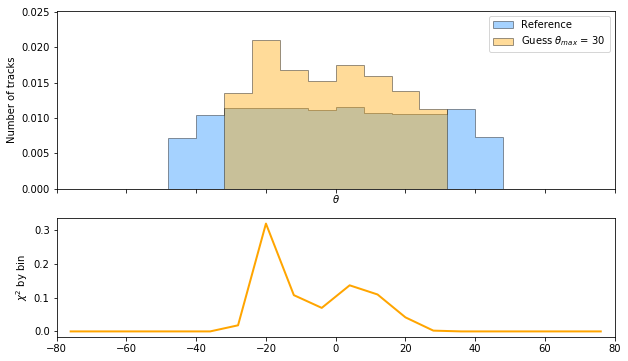

In [32]:
# These were living inside the function, I recompute them here:
distribRefNorm, binEdges  = np.histogram(thetas,          nbins, range=[minx, maxx], density=1)
distribTestNorm,binEdges2 = np.histogram(myGuessedThetas, nbins, range=[minx, maxx], density=1)

figChi, axisObj = plt.subplots(nrows=2, ncols=1, sharex=True, gridspec_kw = {'height_ratios':[3, 2]}, figsize=(10, 6))
binLowEdges = binEdges[:-1]

# I define the range of my axis
axisObj[0].axis([minx, maxx, 0, 1.2*distribTestNorm.max()])

# I plot the normed distribution (plotting-wise it is a plot, already binned)
axisObj[0].hist(thetas,         nbins, range=[minx,maxx], label='Reference', density=True, edgecolor = 'k', facecolor='dodgerblue',histtype='stepfilled', alpha=0.4)
axisObj[0].hist(myGuessedThetas,nbins, range=[minx,maxx], label=r'Guess $\theta_{max}$ = 30', density=True, edgecolor = 'k', facecolor='orange', histtype='stepfilled', alpha=0.4)

axisObj[0].set_xlabel(r"$\theta$")
axisObj[0].set_ylabel("Number of tracks")
axisObj[0].legend()

# I will plot the chiSquare for each bin in the middle of the bin:
binCenters = 0.5 * (binEdges[:-1] + binEdges[1:])
axisObj[1].plot(binCenters, myChiSquaredVals, c='orange', lw=2)
axisObj[1].set_ylabel(r'$\chi^{2}$ by bin')
figChi.canvas.draw()


Let's generate more $\theta_\text{max, guess}$.

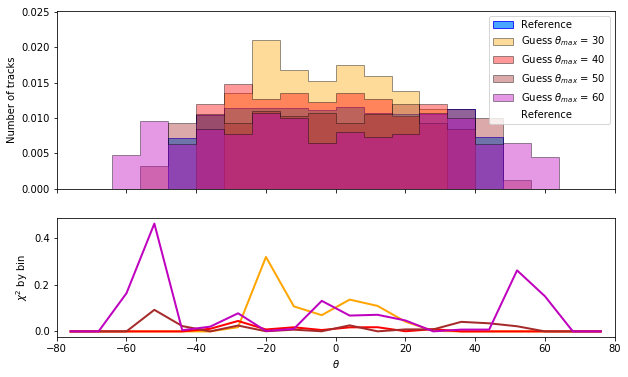

In [63]:
myGuessedThetas40  = getThetaDistributions(40, nPointsGuess)
myGuessedThetas50  = getThetaDistributions(50, nPointsGuess)
myGuessedThetas60  = getThetaDistributions(60, nPointsGuess)

myChiSquaredVals40 = getChiSquaredValues(thetas, myGuessedThetas40, nbins, minx, maxx)
myChiSquaredVals50 = getChiSquaredValues(thetas, myGuessedThetas50, nbins, minx, maxx)
myChiSquaredVals60 = getChiSquaredValues(thetas, myGuessedThetas60, nbins, minx, maxx)

distribRefNorm, binEdges  = np.histogram(thetas,          nbins, range=[minx, maxx], density=1)
distribTestNorm  ,binEdges2 = np.histogram(myGuessedThetas,   nbins, range=[minx, maxx], density=1)
distribTestNorm40,binEdges2 = np.histogram(myGuessedThetas40, nbins, range=[minx, maxx], density=1)
distribTestNorm50,binEdges2 = np.histogram(myGuessedThetas50, nbins, range=[minx, maxx], density=1)
distribTestNorm60,binEdges2 = np.histogram(myGuessedThetas60, nbins, range=[minx, maxx], density=1)

figChi, axisObj = plt.subplots(nrows=2, ncols=1, sharex=True, gridspec_kw = {'height_ratios':[3, 2]}, figsize=(10, 6))
binLowEdges = binEdges[:-1]

# I define the range of my axis
axisObj[0].axis([minx, maxx, 0, 1.2*distribTestNorm.max()])

# I plot the normed distribution (plotting-wise it is a plot, already binned)
axisObj[0].hist(thetas,           nbins, range=[minx,maxx], label='Reference', density=True, edgecolor = 'b', facecolor='dodgerblue',histtype='stepfilled', alpha=0.8)
axisObj[0].hist(myGuessedThetas,  nbins, range=[minx,maxx], label=r'Guess $\theta_{max}$ = 30', density=True, edgecolor = 'k', facecolor='orange', histtype='stepfilled', alpha=0.4)
axisObj[0].hist(myGuessedThetas40,nbins, range=[minx,maxx], label=r'Guess $\theta_{max}$ = 40', density=True, edgecolor = 'k', facecolor='red', histtype='stepfilled', alpha=0.4)
axisObj[0].hist(myGuessedThetas50,nbins, range=[minx,maxx], label=r'Guess $\theta_{max}$ = 50', density=True, edgecolor = 'k', facecolor='brown', histtype='stepfilled', alpha=0.4)
axisObj[0].hist(myGuessedThetas60,nbins, range=[minx,maxx], label=r'Guess $\theta_{max}$ = 60', density=True, edgecolor = 'k', facecolor='m', histtype='stepfilled', alpha=0.4)
axisObj[0].hist(thetas,           nbins, range=[minx,maxx], label='Reference', density=True, edgecolor = 'blue', facecolor='dodgerblue',histtype='stepfilled', alpha=0.0)

axisObj[0].set_ylabel("Number of tracks")
axisObj[0].legend()

# I will plot the chiSquare for each bin in the middle of the bin:
binCenters = 0.5 * (binEdges[:-1] + binEdges[1:])
axisObj[1].plot(binCenters, myChiSquaredVals, c='orange', lw=2)
axisObj[1].plot(binCenters, myChiSquaredVals40, c='red', lw=2)
axisObj[1].plot(binCenters, myChiSquaredVals50, c='brown', lw=2)
axisObj[1].plot(binCenters, myChiSquaredVals60, c='m', lw=2)
axisObj[1].set_xlabel(r"$\theta$")
axisObj[1].set_ylabel(r'$\chi^{2}$ by bin')
figChi.canvas.draw()



Let's see how the sum varies for our different tested $\theta_\text{max, guess}$ values.


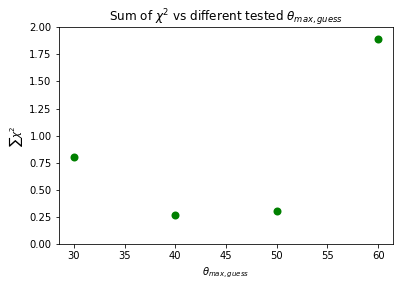

In [52]:
#mySumChiSquared   = getSumFromList(myChiSquaredVals)
mySumChiSquared40  = getSumFromList(myChiSquaredVals40)
mySumChiSquared50  = getSumFromList(myChiSquaredVals50)
mySumChiSquared60  = getSumFromList(myChiSquaredVals60)

myThetaGuessed     = [30, 40, 50, 60]
mySumChiSquared4P  = [mySumChiSquared, mySumChiSquared40, mySumChiSquared50, mySumChiSquared60]

fig = plt.figure()
plt.scatter(myThetaGuessed, mySumChiSquared4P, color='green', lw=2)
plt.xlabel(r"$\theta_{max, guess}$")
plt.ylabel("$\sum \chi^2$")
plt.ylim(0,2)
plt.title(r"Sum of $\chi^2$ vs different tested $\theta_{max, guess}$")
plt.show()

Let's fit this with a polynomial function:

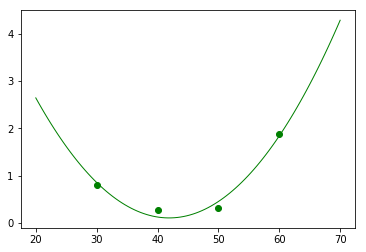

In [54]:
import pylab

# fit the data with a 4th degree polynomial
z2 = np.polyfit(myThetaGuessed, mySumChiSquared4P, 2) 
p2 = np.poly1d(z2) # construct the polynomial 

xx = np.linspace(20, 70, 100)

pylab.plot(myThetaGuessed, mySumChiSquared4P,'og', xx, p2(xx),'-g')
pylab.show()

We see the minimum points towards 45$^\circ$.


In [70]:
# My green curve is the list y:
y = p2(xx)
print(y)

minChi = 1 # it's not
i_min  = -1
for i in range(len(y)):
    if y[i] < minChi:
        i_min = i
        minChi = y[i]

print("\nMin is %.5f"%minChi)
print("Index min ix %d"%i_min)
print("Theta for this index is %.2f"%xx[i_min])
        

[2.64286287 2.52715262 2.41414227 2.30383184 2.19622131 2.09131068
 1.98909996 1.88958915 1.79277824 1.69866724 1.60725615 1.51854496
 1.43253368 1.3492223  1.26861083 1.19069927 1.11548761 1.04297586
 0.97316401 0.90605207 0.84164004 0.77992791 0.72091569 0.66460338
 0.61099097 0.56007847 0.51186587 0.46635318 0.4235404  0.38342752
 0.34601455 0.31130148 0.27928832 0.24997507 0.22336172 0.19944828
 0.17823474 0.15972111 0.14390739 0.13079357 0.12037966 0.11266566
 0.10765156 0.10533737 0.10572308 0.1088087  0.11459423 0.12307966
 0.134265   0.14815024 0.1647354  0.18402045 0.20600541 0.23069028
 0.25807506 0.28815974 0.32094433 0.35642882 0.39461322 0.43549753
 0.47908174 0.52536586 0.57434988 0.62603381 0.68041765 0.73750139
 0.79728504 0.85976859 0.92495206 0.99283542 1.0634187  1.13670188
 1.21268496 1.29136795 1.37275085 1.45683365 1.54361636 1.63309898
 1.7252815  1.82016393 1.91774627 2.01802851 2.12101065 2.22669271
 2.33507466 2.44615653 2.5599383  2.67641998 2.79560156 2.9174

We found a $\theta_{max, prediction}$ of 41.72. A bit far of 45, but close.
